# **Cloud Intrusion Detection Method Based on Stacked Contractive Auto-Encoder and Support Vector Machine**

## Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install libraries

In [ ]:
pip install tensorflow numpy pandas scikit-learn matplotlib seaborn

## Import modules

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import tensorflow.keras.backend as K
import joblib
import os

from tensorflow.keras.losses import Loss
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
#from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc
from sklearn.svm import LinearSVC

from pandas.api.types import is_numeric_dtype

from scipy.stats import zscore

from keras.saving import register_keras_serializable
from keras import backend as K

In [ ]:
print(tf.__version__)

2.18.0


In [ ]:
drive_path = "/content/drive/MyDrive/models"
os.makedirs(drive_path, exist_ok=True)

## Load dataset

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/arff dataset.csv")

In [ ]:
df.shape

(125973, 43)

In [ ]:
df.head()

,id,duration',protocol_type',service',flag',src_bytes',dst_bytes',land',wrong_fragment',urgent',hot',num_failed_logins',logged_in',num_compromised',root_shell',su_attempted',num_root',num_file_creations',num_shells',num_access_files',num_outbound_cmds',is_host_login',is_guest_login',count',srv_count',serror_rate',srv_serror_rate',rerror_rate',srv_rerror_rate',same_srv_rate',diff_srv_rate',srv_diff_host_rate',dst_host_count',dst_host_srv_count',dst_host_same_srv_rate',dst_host_diff_srv_rate',dst_host_same_src_port_rate',dst_host_srv_diff_host_rate',dst_host_serror_rate',dst_host_srv_serror_rate',dst_host_rerror_rate',dst_host_srv_rerror_rate',class'
0,1,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,2,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,3,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,4,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,5,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


## Data exploration

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            125973 non-null  int64  
 1   duration'                     125973 non-null  int64  
 2   protocol_type'                125973 non-null  object 
 3   service'                      125973 non-null  object 
 4   flag'                         125973 non-null  object 
 5   src_bytes'                    125973 non-null  int64  
 6   dst_bytes'                    125973 non-null  int64  
 7   land'                         125973 non-null  int64  
 8   wrong_fragment'               125973 non-null  int64  
 9   urgent'                       125973 non-null  int64  
 10  hot'                          125973 non-null  int64  
 11  num_failed_logins'            125973 non-null  int64  
 12  logged_in'                    125973 non-nul

In [ ]:
df.describe()

,id,duration',src_bytes',dst_bytes',land',wrong_fragment',urgent',hot',num_failed_logins',logged_in',num_compromised',root_shell',su_attempted',num_root',num_file_creations',num_shells',num_access_files',num_outbound_cmds',is_host_login',is_guest_login',count',srv_count',serror_rate',srv_serror_rate',rerror_rate',srv_rerror_rate',same_srv_rate',diff_srv_rate',srv_diff_host_rate',dst_host_count',dst_host_srv_count',dst_host_same_srv_rate',dst_host_diff_srv_rate',dst_host_same_src_port_rate',dst_host_srv_diff_host_rate',dst_host_serror_rate',dst_host_srv_serror_rate',dst_host_rerror_rate',dst_host_srv_rerror_rate'
count,125973.000000,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.0,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,62987.000000,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,0.001342,0.001103,0.302192,0.012669,0.000413,0.004096,0.0,0.000008,0.009423,84.107555,27.737888,0.284485,0.282485,0.119958,0.121183,0.660928,0.063053,0.097322,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,36365.417068,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,0.036603,0.045154,24.399618,0.483935,0.022181,0.099370,0.0,0.002817,0.096612,114.508607,72.635840,0.446456,0.447022,0.320436,0.323647,0.439623,0.180314,0.259830,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,1.000000,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31494.000000,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,62987.000000,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,94480.000000,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,143.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,125973.000000,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,0.0,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Preprocessing the dataset

In [ ]:
#checking the dataset for null or missing values
total = df.shape[0]
missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
for col in missing_columns:
    null_count = df[col].isnull().sum()
    per = (null_count/total) * 100
    print(f"{col}: {null_count} ({round(per, 3)}%)")

No null or missing values found in the dataset

In [ ]:
print(f"Number of duplicate rows: {df.duplicated().sum()}")

Number of duplicate rows: 0


No duplicate rows found in the dataset

In [ ]:
categorical_features = ["protocol_type'", "service'", "flag'", "class'"]
encoders = {col: LabelEncoder() for col in categorical_features}

for col in categorical_features:
    df[col] = encoders[col].fit_transform(df[col])

In [ ]:
df["class'"] = df["class'"].apply(lambda x: 0 if x == encoders["class'"].transform(['normal'])[0] else 1)

In [ ]:
df["class'"].value_counts()

,count
class',
0,67343
1,58630


<Axes: >

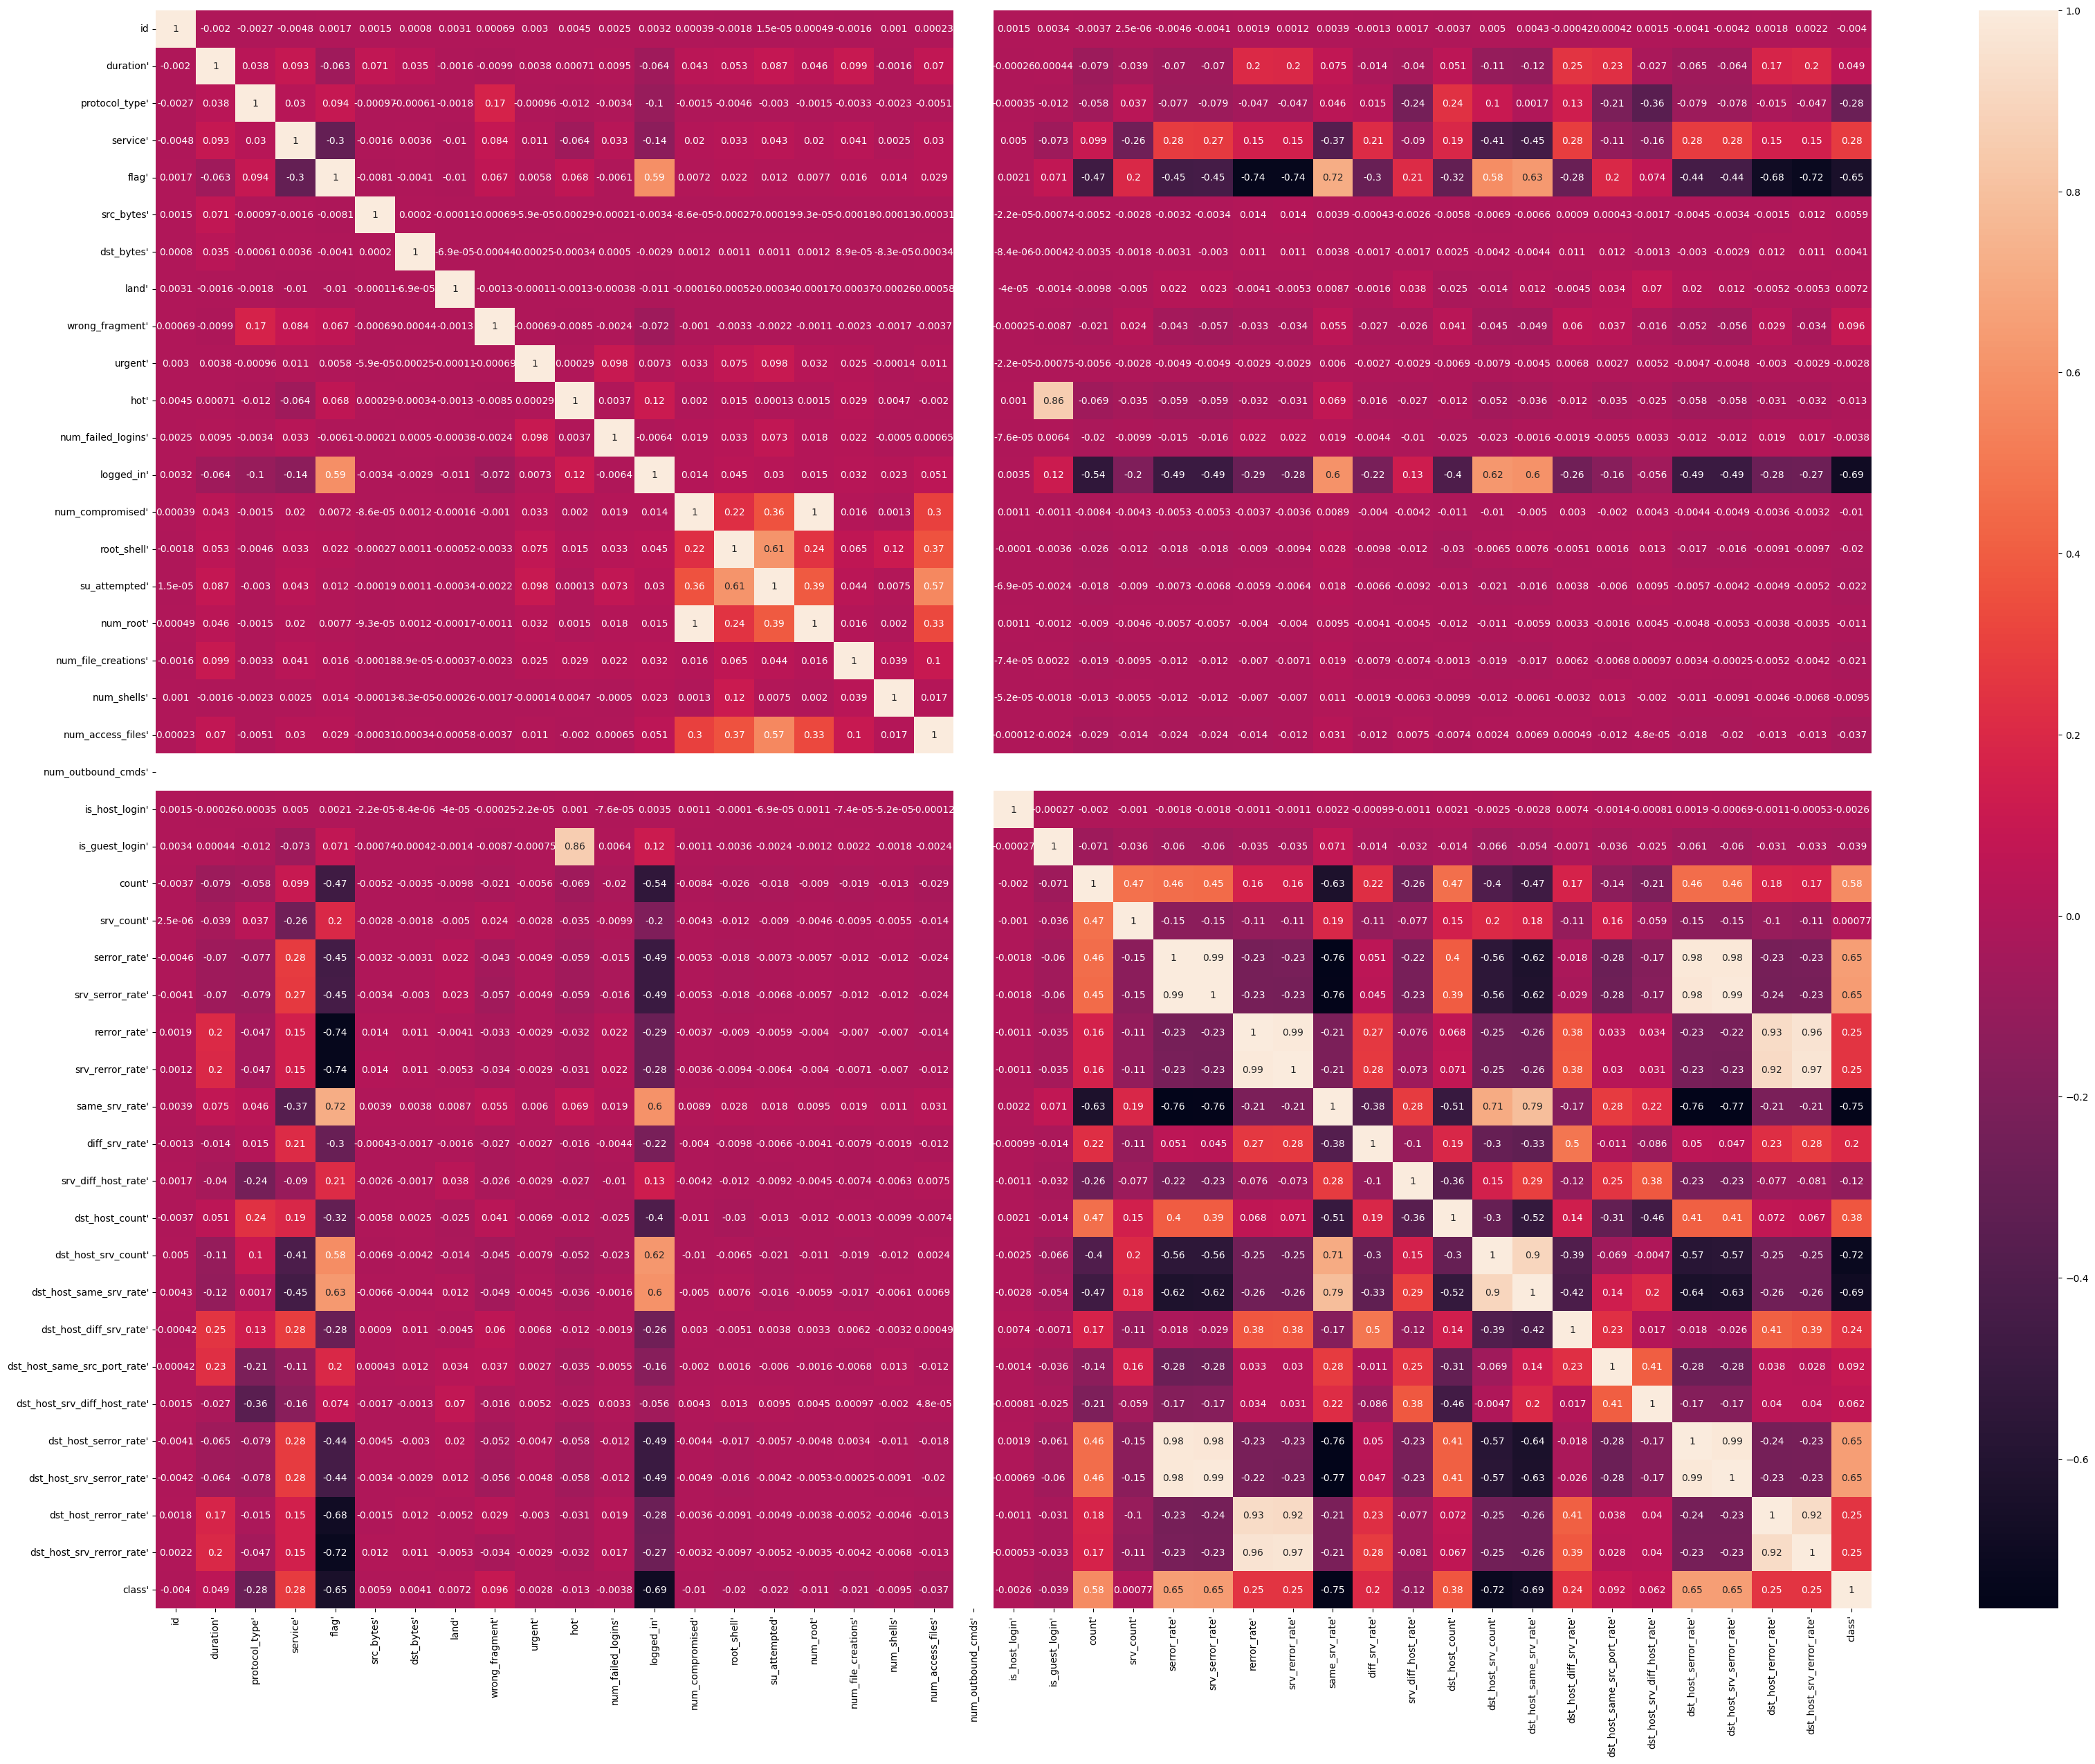

In [ ]:
plt.figure(figsize=(40,30))
sns.heatmap(df.corr(), annot=True)

In [ ]:
X_train = df.drop(["class'"], axis=1)
Y_train = df["class'"]

In [ ]:
# Identify columns with low correlation to "class'"
correlation_matrix = df.corr()
class_correlation = correlation_matrix["class'"].abs().sort_values(ascending=False)
threshold = 0.05  #drop columns with correlation less than 0.05

columns_to_drop = class_correlation[class_correlation < threshold].index.tolist()
print("Columns to drop:", columns_to_drop)


Columns to drop: ["duration'", "is_guest_login'", "num_access_files'", "su_attempted'", "num_file_creations'", "root_shell'", "hot'", "num_root'", "num_compromised'", "num_shells'", "land'", "src_bytes'", "dst_bytes'", 'id', "num_failed_logins'", "urgent'", "is_host_login'", "srv_count'"]


Out of 39 features, 14 will be dropped due to low correlation with the attack type feature

In [ ]:
# Drop the columns
df = df.drop(columns=columns_to_drop)

In [ ]:
df.head()

,protocol_type',service',flag',wrong_fragment',logged_in',num_outbound_cmds',count',serror_rate',srv_serror_rate',rerror_rate',srv_rerror_rate',same_srv_rate',diff_srv_rate',srv_diff_host_rate',dst_host_count',dst_host_srv_count',dst_host_same_srv_rate',dst_host_diff_srv_rate',dst_host_same_src_port_rate',dst_host_srv_diff_host_rate',dst_host_serror_rate',dst_host_srv_serror_rate',dst_host_rerror_rate',dst_host_srv_rerror_rate',class'
0,1,20,9,0,0,0,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,2,44,9,0,0,0,13,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,1,49,5,0,0,0,123,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
3,1,24,9,0,1,0,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,1,24,9,0,1,0,30,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


Drop the attack type feature from the train dataset to divide it into X and Y. X being the input features and Y being the label

In [ ]:
X_train = df.drop(["class'"], axis=1)
Y_train = df["class'"]

## Selecting the best features from the dataset to train the model

Recursive Feature Elimination is used to identify the best features to train the model on

In [ ]:
rfc = RandomForestClassifier()

rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X_train, Y_train)

feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X_train.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

["protocol_type'",
 "service'",
 "flag'",
 "logged_in'",
 "count'",
 "same_srv_rate'",
 "diff_srv_rate'",
 "dst_host_srv_count'",
 "dst_host_same_srv_rate'",
 "dst_host_same_src_port_rate'"]

Replace the features in the dataset with the ones listed above

In [ ]:
X_train = X_train[selected_features]

Split the dataset into train and test

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.70, random_state=2)

Normalise the dataset

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)

## Building the stacked contractive auto-encoder model

In [ ]:
@register_keras_serializable()
class ContractiveLoss(tf.keras.losses.Loss):
    def __init__(self, autoencoder, lam=1e-4, name="contractive_loss"):
        super().__init__(name=name)
        self.autoencoder = autoencoder
        self.lam = lam

    def call(self, y_true, y_pred):
        encoder_layer = self.autoencoder.get_layer(index=1)  # First Dense layer (128 units)
        W = encoder_layer.weights[0]
        W = tf.transpose(W)

        h = encoder_layer(y_pred)
        dh = tf.cast(h > 0, tf.float32)  # Derivative of ReLU

        contractive_penalty = self.lam * tf.reduce_sum(dh ** 2 * tf.reduce_sum(W ** 2, axis=1))
        return tf.reduce_mean(tf.square(y_true - y_pred)) + contractive_penalty


# Step 1: Build Autoencoder
input_dim = X_train.shape[1]
encoding_dim = 16

input_layer = tf.keras.Input(shape=(input_dim,))
encoded = tf.keras.layers.Dense(128, activation='relu')(input_layer)
encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(encoded)

decoded = tf.keras.layers.Dense(28, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(input_dim, activation='linear')(decoded)

autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoded)

# Step 2: Compile with custom loss AFTER building the model
loss_fn = ContractiveLoss(autoencoder)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss=loss_fn)

# Step 3: Train
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history = autoencoder.fit(x_train, x_train,
                          epochs=50,
                          batch_size=32,
                          validation_data=(x_test, x_test),
                          callbacks=[early_stopping])

Epoch 1/50
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 446.7344 - val_loss: 0.1686
Epoch 2/50
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.1312 - val_loss: 0.0996
Epoch 3/50
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0851 - val_loss: 0.0709
Epoch 4/50
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0751 - val_loss: 0.0588
Epoch 5/50
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.0780 - val_loss: 0.0483
Epoch 6/50
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0660 - val_loss: 0.1202
Epoch 7/50
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0650 - val_loss: 0.0394
Epoch 8/50
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0773 - val_loss: 0.1022
Epoch 9/50
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0574 - val_loss: 0.0318
Epoch 10/50
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0391 - val_loss: 0.0385
Epoch 11/50
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0554 - val_loss: 0.0309
Epoch 12/50
2756/2

Understanding Each Part
Epoch n/50 → This is the nth iteration of training, out of 50 total epochs.

2756/2756 → The dataset is split into 2756 batches per epoch.

xs yms/step → Each training step takes about y milliseconds, and the full epoch takes x seconds.

loss → training loss

val_loss → validation loss

Extract features

In [ ]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(index=2).output)
X_train_encoded = encoder.predict(x_train)
X_test_encoded = encoder.predict(x_test)

2756/2756 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


## Training the SVM

In [ ]:
# Use LinearSVC for better scalability
svm = LinearSVC(C=1, dual=False, max_iter=5000)  # Increase max_iter if needed
svm.fit(X_train_encoded, y_train)

# Predictions
y_pred = svm.predict(X_test_encoded)

# Evaluate Model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     20132
           1       0.94      0.93      0.93     17660

    accuracy                           0.94     37792
   macro avg       0.94      0.94      0.94     37792
weighted avg       0.94      0.94      0.94     37792



## Downloading .h5 file

In [ ]:
print(autoencoder.loss)  # Should print something like: <__main__.ContractiveLoss object ...>

In [ ]:
# Save Autoencoder in Keras format
autoencoder.save("scae_model.keras")

# Or, for TensorFlow Serving (optional, not both):
# autoencoder.export("scae_model_tf")

# Save Encoder
encoder.save(os.path.join(drive_path, "encoder_model.h5"))

# Save SVM Model
joblib.dump(svm, os.path.join(drive_path, "svm_model.pkl"))

print("Models saved to Google Drive successfully! 🚀")

Models saved to Google Drive successfully! 🚀


## Features and their meaning

🔍 Feature Descriptions
Feature	Meaning
1. Protocol Type	Network protocol used in the connection:
• 0 = TCP, 1 = UDP, 2 = ICMP (after label encoding).
2. Service	The network service on the destination (e.g., HTTP, FTP, SMTP). After encoding, it’s numeric.
3. Flag	Status flag of the connection (e.g., SF = successful, REJ = rejected). Encoded numerically.
4. Logged In	Whether the connection is from a logged-in user.
• 1 = yes, 0 = no.
5. Count	Number of connections from the same source IP in the past 2 seconds. Indicates burst behavior.
6. Same Srv Rate	Percentage of connections to the same service. Shows if the host is targeting a specific port.
7. Diff Srv Rate	Percentage of connections to different services. High value may indicate scanning activity.
8. Dst Host Srv Count	Number of connections to the same service, to the same destination host. High values = target focus.
9. Dst Host Same Srv Rate	Ratio of connections with the same service to the total connections with that destination host.
10. Dst Host Same Src Port Rate	Ratio of connections to the same destination host and same source port.
High values could indicate a script or bot using a fixed source port.

Intrusion
1.   Protocol Type: 1
2. Service: 25
3. Flag: 2
4. Logged In: 0
5. Count: 500
6. Same Srv Rate: 0.02
7. Diff Srv Rate: 0.9
8. Dst Host Srv Count: 255
9. Dst Host Same Srv Rate: 0.03
10. Dst Host Same Src Port Rate: 0.1



Normal
1.   Protocol Type: 0
2. Service: 2
3. Flag: 0
4. Logged In: 1
5. Count: 5
6. Same Srv Rate: 0.9
7. Diff Srv Rate: 0.05
8. Dst Host Srv Count: 30
9. Dst Host Same Srv Rate: 0.95
10. Dst Host Same Src Port Rate: 0.85